# San Francisco Crime Classification

### Data fields

- Dates - timestamp of the crime incident
- Category - category of the crime incident (only in train.csv). This is the target variable you are going to predict.
- Descript - detailed description of the crime incident (only in train.csv)
- DayOfWeek - the day of the week
- PdDistrict - name of the Police Department District
- Resolution - how the crime incident was resolved (only in train.csv)
- Address - the approximate street address of the crime incident 
- X - Longitude
- Y - Latitude

### Importing libraries

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Importing datasets

In [81]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

### Train dataset

In [82]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [83]:
train_df.shape

(878049, 9)

In [84]:
train_df.describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


**Note:**

Max. Y = 90, it can be some outlier

In [85]:
train_df.describe(include=['O'])

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address
count,878049,878049,878049,878049,878049,878049,878049
unique,389257,39,879,7,10,17,23228
top,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST
freq,185,174900,60022,133734,157182,526790,26533


In [86]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


**Note:**

We don't have any null values in our train dataset

### Test dataset

In [87]:
test_df.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [88]:
test_df.shape

(884262, 7)

**Note:**

Test dataset doesn't have Category, Descript and Resolution columns

In [89]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
Id            884262 non-null int64
Dates         884262 non-null object
DayOfWeek     884262 non-null object
PdDistrict    884262 non-null object
Address       884262 non-null object
X             884262 non-null float64
Y             884262 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 47.2+ MB


**Note:**

We don't have any null values in our train dataset

## Analysis

How many crimes are there per category?

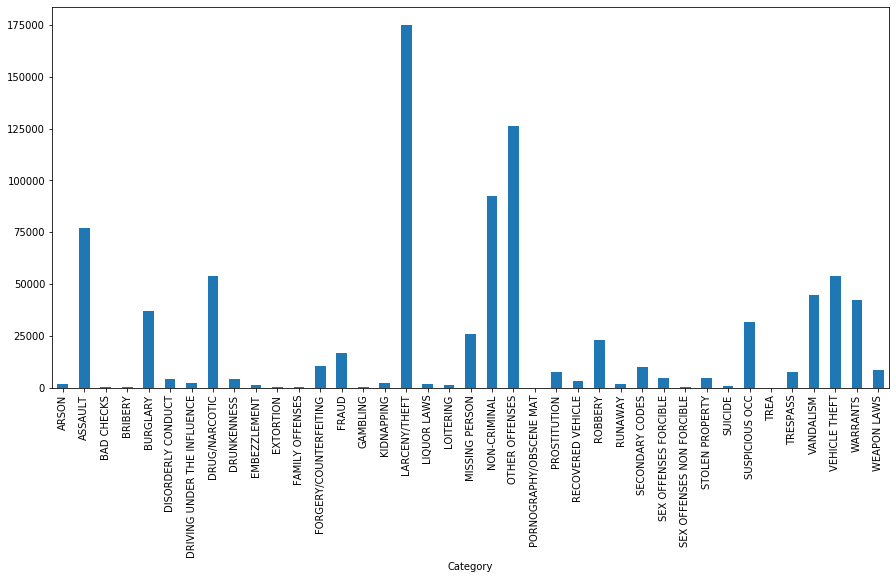

In [90]:
df_category = train_df.groupby(['Category'])['Dates'].count()
df_category.plot(kind='bar',figsize=(15,7))

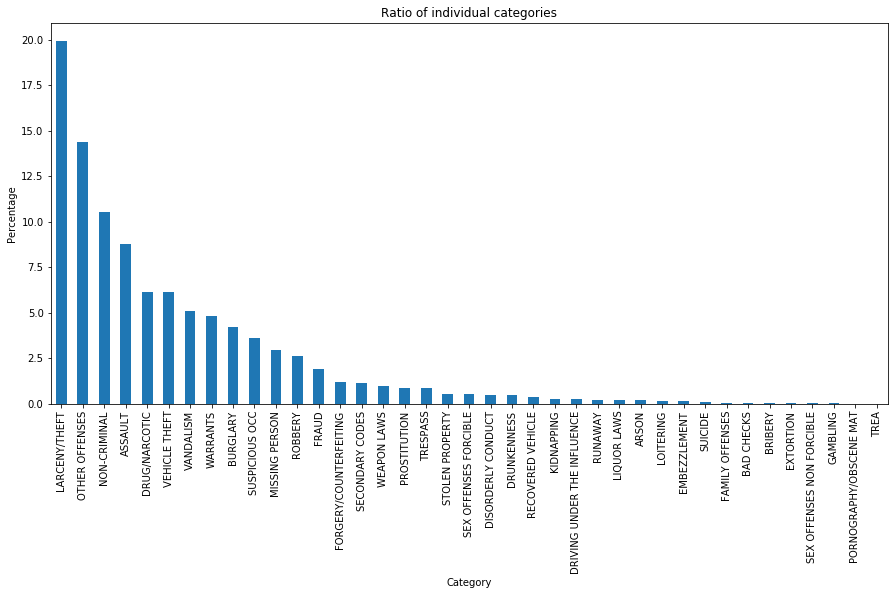

In [91]:
df_cat_percentage = (df_category/df_category.sum()*100).sort_values(ascending=False)
title = "Ratio of individual categories"
plt.figure()
df_cat_percentage.plot(kind='bar',figsize=(15,7), title=title)
plt.ylabel('Percentage')
plt.show()

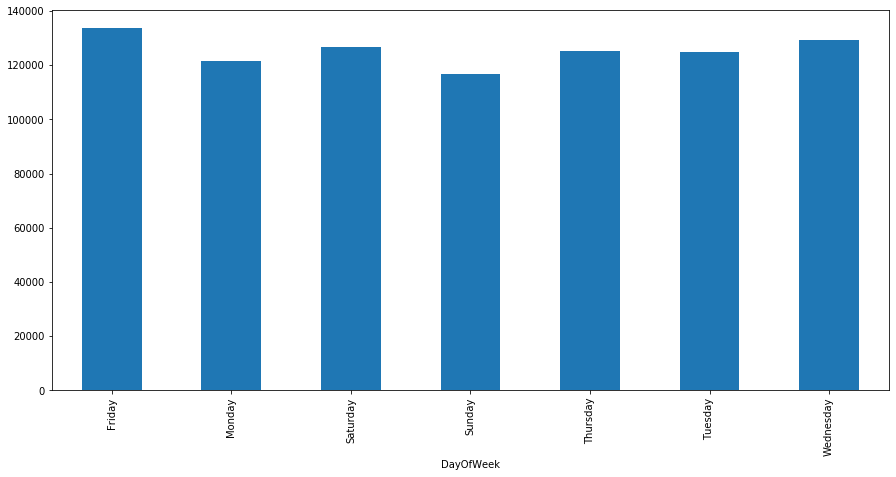

In [92]:
df_dayOfWeek = train_df.groupby(['DayOfWeek'])['Dates'].count()
df_dayOfWeek.plot(kind='bar',figsize=(15,7))

**Note:**

There is a similar number of crimes each day of the week

### Extract part of day from *Dates* column

- 02:00-06:00 is **Dawn**
- 06:00-10:00 is **Morning**
- 10:00-14:00 is **Noon**
- 14:00-18:00 is **After noon**
- 18:00-22:00 is **Evening**
- 22:00-02:00 is **Night**

In [93]:
train_df['Dates'] = pd.to_datetime(train_df['Dates'])

#### Define function which tells which part of the day is it

In [95]:
hour_2 = pd.to_datetime('2:00:00').time()
hour_6 = pd.to_datetime('6:00:00').time()
hour_10 = pd.to_datetime('10:00:00').time()
hour_14 = pd.to_datetime('14:00:00').time()
hour_18 = pd.to_datetime('18:00:00').time()
hour_22 = pd.to_datetime('22:00:00').time()
def get_part_of_day(time):
    return (
        "Dawn" if hour_2 <= time < hour_6
        else
        "Morning" if hour_6 <= time < hour_10
        else
        "Noon" if hour_10 <= time < hour_14
        else
        "After Noon" if hour_14 <= time < hour_18
        else
        "Evening" if hour_18 <= time < hour_22
        else 
        "Night"
    )

In [96]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 60.3+ MB


In [97]:
train_df['PartOfDay'] = train_df['Dates'].dt.time.apply(get_part_of_day)

In [99]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,PartOfDay
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,Night
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,Night
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,Night
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,Night
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,Night
